# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Вам нужно:**

1. Подготовить данные:
* Изучить данные, удалить неинформативные признаки
* Предобработать данные

2. Построить и обучить модели:
* Градиентного бустинга на деревьях
* Случайного леса

3. Провести сравнительный анализ моделей
* Сравнить качество и время предикта

4. Протестировать наилучшую модель

## Подготовка данных

### Первичный анализ

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor, cv, Pool
import lightgbm as lgb
from scipy.stats import randint

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

In [5]:
df.columns = [col.lower() for col in df.columns]

In [6]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

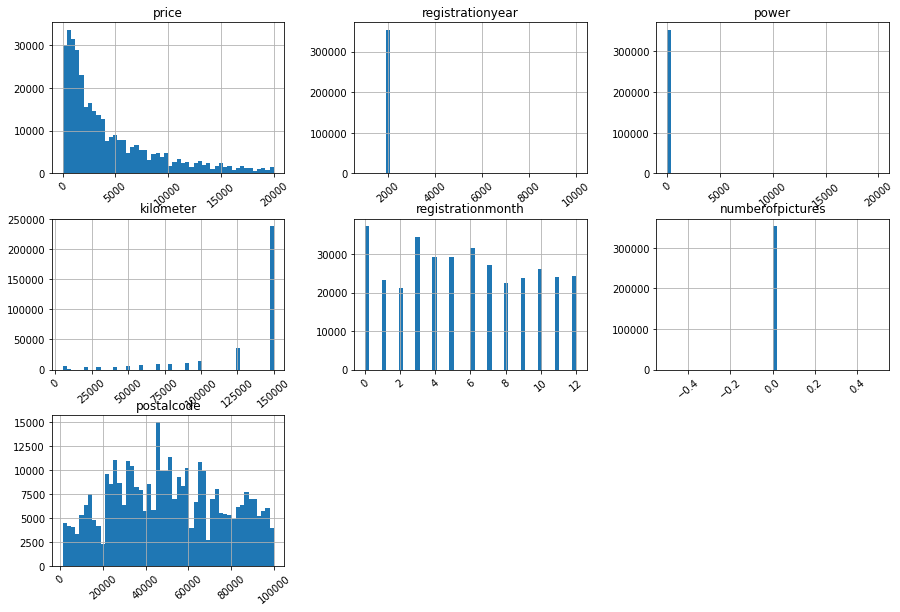

In [8]:
df.hist(figsize=(15,10), bins=50, xrot=40);

In [9]:
df.drop(columns=['datecrawled']).duplicated().sum()

89

In [10]:
df.drop_duplicates(subset=df.columns[1:], inplace=True)

### Обработка

Сразу видны проблемы в данных:
* Не хватает id пользователя для отслеживания дубликатов
* Год регистрации и мощность автомобиля не все указывают верно
* Число фото неинформативно
* Для анализа дат необходимо привести их к одному формату daytime или взять хотя бы год
* Что-то нужно сделать с индексом

Почтовый индекс, в теории, может влиять на стоимость автомобиля. Первые три цифры отвечают за город, последние за отделение почты. Логично что в каких-то городах средняя стоимость автомобилей может сильно разниться, однако более точно будет предсказывать стоимость марка и модель авто, нежели город. К тому же это лишние категориальные признаки. Дропнем его

In [11]:
df.drop(columns=['numberofpictures', 'postalcode'], inplace=True)

In [12]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'], format='%Y.%m.%dT%H:%M:%S')
df['datecreated'] = pd.to_datetime(df['datecreated'], format='%Y.%m.%dT%H:%M:%S')
df['lastseen'] = pd.to_datetime(df['lastseen'], format='%Y.%m.%dT%H:%M:%S')

#### Обработка выбросов даты регистрации

In [13]:
df['registrationyear'].quantile(0.999)

2018.0

In [14]:
df['registrationyear'].quantile(0.01)

1980.0

In [15]:
df = df[df['registrationyear'] <= 2018]

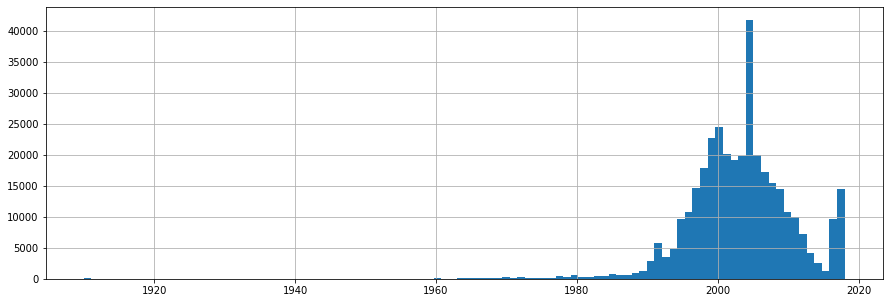

In [16]:
df.query('registrationyear > 1900')['registrationyear'].hist(figsize=(15,5), bins=100);

Если все что младше 2018 и старше 1960 года очевидно ошибка, то все что осталось в промежутке это вполне возможно. Дропать ли экстремальные значения вопрос филосовский. Если наша цель улучшить качество в среднем, а не на редкой группе, то стоит отбросить эти значения на тренировочной выборке.

#### Обработка выбросов мощности авто

In [17]:
df['power'].quantile(0.998)

418.8079999999609

Все что больше 400 это скорее всего выброс, нежели экстремальное значение - дропем перед формированием выборок

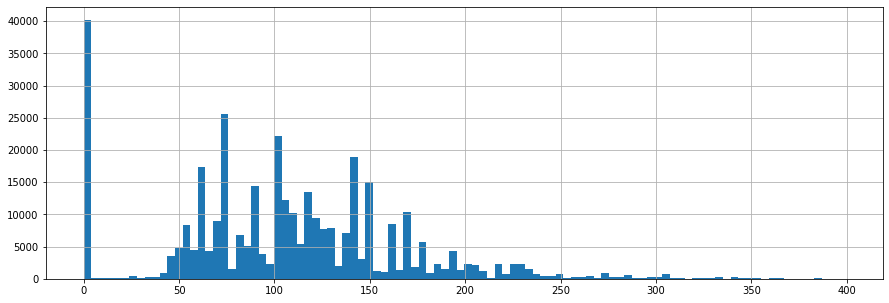

In [18]:
df.query('power < 400')['power'].hist(figsize=(15,5), bins=100);

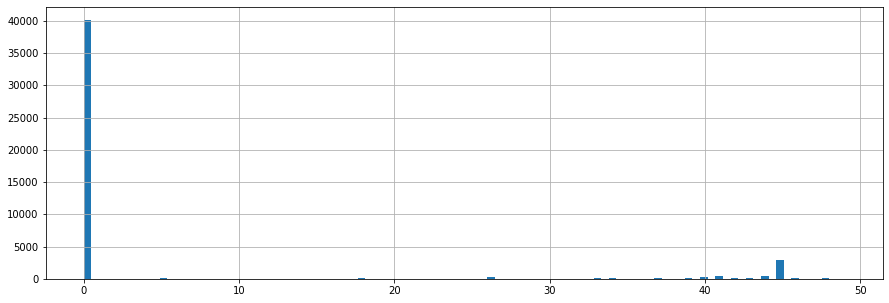

In [19]:
df.query('power < 50')['power'].hist(figsize=(15,5), bins=100);

In [20]:
df.query('power == 0')[['model', 'brand', 'price']].head(10)

,model,brand,price
0,golf,volkswagen,480
15,ka,ford,450
32,golf,volkswagen,245
37,kangoo,renault,1500
40,corsa,opel,0
54,signum,opel,4700
55,astra,opel,550
69,astra,opel,1200
70,polo,volkswagen,800
90,a4,audi,2400


In [21]:
df.query('power != 0')[['model', 'brand', 'price']].head(10)

,model,brand,price
1,NaN,audi,18300
2,grand,jeep,9800
3,golf,volkswagen,1500
4,fabia,skoda,3600
5,3er,bmw,650
6,2_reihe,peugeot,2200
7,other,volkswagen,0
8,c_max,ford,14500
9,golf,volkswagen,999
10,3_reihe,mazda,2000


Видно, что есть одинаковые модели в случае с нулевой мощностью и ненулевой. Посмотрим, это недочет пользователей, или это чем-то обусловлено

In [22]:
df_check = df.copy()
df_check['is_power_zero'] = df_check['power'].apply(lambda x: x == 0)

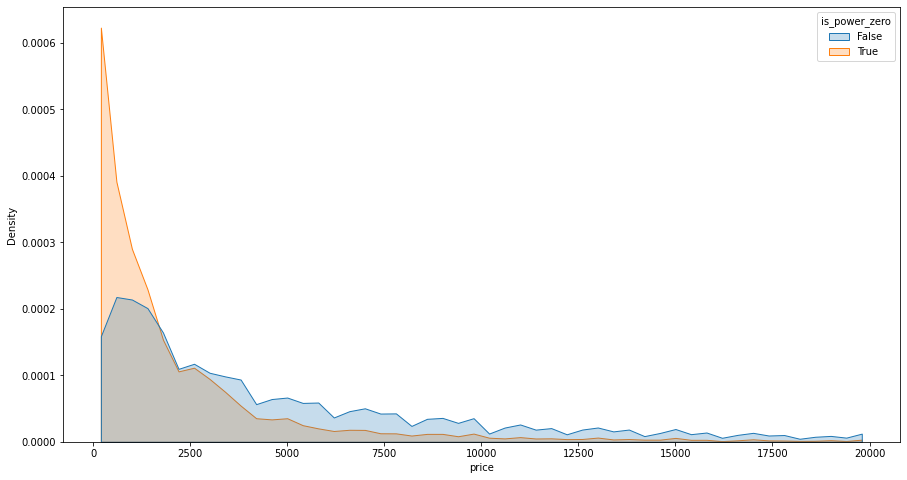

In [23]:
sns.histplot(df_check, x='price', hue='is_power_zero', element="poly", bins = 50, stat="density", common_norm=False)
plt.gcf().set_size_inches(15,8);

Судя о том что авто без мощности в целом стоят меньше наводит на мысль что они оказались в этой категории не случайно - дропать не станем

#### Обработка даты создания заявления, даты выгрузки и даты последней активности

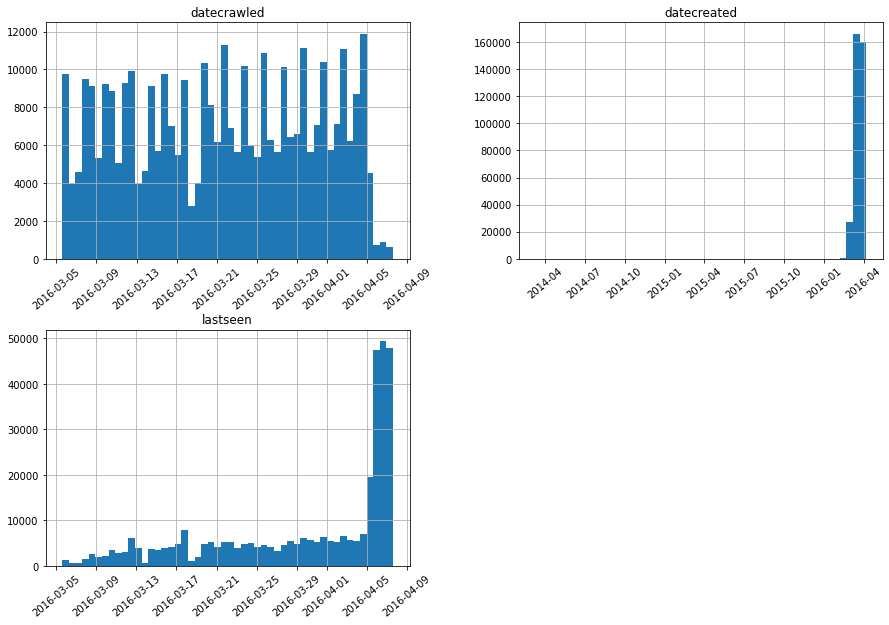

In [24]:
df[['datecrawled', 'datecreated', 'lastseen']].hist(figsize=(15,10), bins=50, xrot=40);

Сам по себе год продажи мало на что влияет, а вот разность между годом продажи и регистрацией имеет уже несколько больший смысл. Однако здесь это не имеет значения - год продажи почти не меняется - данные за 16 - 18 года, поэтому от этого не будет толка. Дропнем дату продажи, время последней активности а так же дату выгрузки заявления, оставим лишь год регистрации.

In [25]:
df.drop(columns=['datecrawled', 'datecreated', 'registrationmonth', 'lastseen'], inplace=True)

#### Обработка пропусков

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354150 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354150 non-null  int64 
 1   vehicletype       316790 non-null  object
 2   registrationyear  354150 non-null  int64 
 3   gearbox           334405 non-null  object
 4   power             354150 non-null  int64 
 5   model             334492 non-null  object
 6   kilometer         354150 non-null  int64 
 7   fueltype          321344 non-null  object
 8   brand             354150 non-null  object
 9   repaired          283101 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [27]:
df['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [28]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [29]:
df['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [30]:
df['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [31]:
df.fillna('unknown', inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354150 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354150 non-null  int64 
 1   vehicletype       354150 non-null  object
 2   registrationyear  354150 non-null  int64 
 3   gearbox           354150 non-null  object
 4   power             354150 non-null  int64 
 5   model             354150 non-null  object
 6   kilometer         354150 non-null  int64 
 7   fueltype          354150 non-null  object
 8   brand             354150 non-null  object
 9   repaired          354150 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [33]:
df.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown


#### Проверка корреляций

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer']


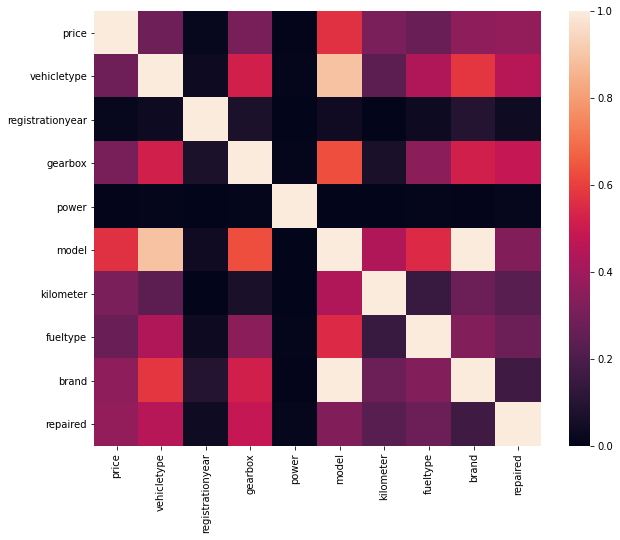

In [34]:
sns.heatmap(df.phik_matrix())
plt.gcf().set_size_inches(10,8);

Год регистрации и мощность двигателя практически не влияют на стоимость авто - можно отбросить эти признаки если модель будет плохо обучаться

### Формирование выборок

In [36]:
categorical_columns = [
    'vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired'
]
numerical_columns = ['registrationyear', 'power', 'kilometer']


In [37]:
for feature in categorical_columns:
    df[feature] = pd.Series(df[feature], dtype="category")

In [38]:
X_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['price']), df['price'], 
                                                    test_size=0.25, random_state=42)

## Обучение моделей

Обучать будем деревянные модели, подберем для них сходные гиперпараметры и выберем наилучшие для каждой модели

In [39]:
models_info_df = pd.DataFrame(index=['fit_time, s', 'pred_time, s', 'rmse'])

In [40]:
def add_data_to_df(model, name, df=models_info_df):
    df[name] = ([
        model.refit_time_,
        model.cv_results_['mean_score_time'][model.cv_results_['mean_test_score'].argmin()],
        abs(model.best_score_)
    ])

### Случайный лес

In [41]:
categorical_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)],
    n_jobs=-1
)

In [42]:
pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestRegressor())])

grid={
    'clf__max_depth':list(np.arange(3, 40, step=3)),
    'clf__n_estimators':np.arange(10, 100, step=10),
    'clf__max_features':np.arange(1, 7),
    'clf__min_samples_leaf':np.arange(1, 4),
    'clf__min_samples_split':np.arange(2, 10, step=2)
}

random_forest_model = RandomizedSearchCV(pipe, grid, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
random_forest_model.fit(X_train, y_train);

#cross_val_score(pipe, X_train, y_train, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3)

In [43]:
add_data_to_df(random_forest_model, 'random_forest_model')

In [44]:
models_info_df.T

,"fit_time, s","pred_time, s",rmse
random_forest_model,29.554896,0.30513,1751.165988


In [45]:
random_forest_model.best_params_ 

{'clf__n_estimators': 80,
 'clf__min_samples_split': 8,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 4,
 'clf__max_depth': 27}

### CatBoost

In [46]:
#cv_dataset = Pool(data=X_train, label=y_train, cat_features=categorical_columns)
#cat_boost_model = CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=False) 

#grid = {'learning_rate': [0.1, 0.3, 0.5],
#        'depth': [6, 10, 12]}
#
#grid_search_result = cat_boost_model.grid_search(grid, cv_dataset, plot=True, cv=3)

In [47]:
pipe = Pipeline([('pre', preprocessor), ('clf', CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=False))])

grid={
    'clf__depth':[6, 10, 12],
    'clf__learning_rate': [0.3, 0.5, 1]
}

cat_boost_model = GridSearchCV(pipe, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
cat_boost_model.fit(X_train, y_train);

In [48]:
add_data_to_df(cat_boost_model, 'cat_boost_model')

In [49]:
models_info_df.T

,"fit_time, s","pred_time, s",rmse
random_forest_model,29.554896,0.30513,1751.165988
cat_boost_model,13.112234,0.36885,1767.580539


In [50]:
cat_boost_model.best_params_ 

{'clf__depth': 12, 'clf__learning_rate': 0.3}

### LGBoost

In [52]:
pipe = Pipeline([('pre', preprocessor), ('clf', lgb.LGBMModel(objective="regression", n_estimators=100))])

grid={
    'clf__max_depth':[6, 10, 12],
    'clf__learning_rate': [0.3, 0.5, 1]
}

lgboost_model = GridSearchCV(pipe, grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgboost_model.fit(X_train, y_train);

In [53]:
add_data_to_df(lgboost_model, 'lgboost_model')

In [54]:
models_info_df.T

,"fit_time, s","pred_time, s",rmse
random_forest_model,29.554896,0.305130,1751.165988
cat_boost_model,13.112234,0.368850,1767.580539
lgboost_model,4.489944,0.574689,1795.669744


In [55]:
lgboost_model.best_params_ 

{'clf__learning_rate': 0.3, 'clf__max_depth': 12}

## Анализ моделей и вывод

In [56]:
models_info_df.T

,"fit_time, s","pred_time, s",rmse
random_forest_model,29.554896,0.305130,1751.165988
cat_boost_model,13.112234,0.368850,1767.580539
lgboost_model,4.489944,0.574689,1795.669744


Заказчику важна не только метрика качества, но и время фита и предикта. Среди обученных моделей метрика качества меняется не сильно, как и время предикта, а вот время фита наоборот. Для lgboost `fit_time` на порядок меньше чем у других моделей, протестируем его. 

In [57]:
mean_squared_error(y_test, lgboost_model.predict(x_test))**0.5

1786.7661908577647

Как видно, модель прекрасно предсказывает тестовую выборку, сверим значения с наивным регрессором

In [58]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

mean_squared_error(y_test, dummy.predict(x_test))**0.5

4523.773673727047

Как видно,  lgboost показывает себя значительно лучше, а значит модель адекватна

## Вывод
* Быстрее всех среди деревянных моделей обучается LightGBM.
* Самые лучшие метрики у CatBoost и random_forest. Они отличаются незначительно. Но и скорость обучения самая долгая.
* Самые оптимальные показатели времени предсказания/качества модели - LightGBM.

* В целом, все модели предсказывают довольно быстро - меньше секунды, но все же для заказчика важна скорость предсказания и метрика, потому лучшая модель - LightGBM с параметрами: max_depth: 12, learning_rate: 0.3, n_estimators=100